# mCorrect:  multiset CORRelation Estimation and deteCTion.

Given a multi-modal dataset, this toolbox estimates the following:
* The number of correlated components across the datasets.
* The structure of the correlated components

The toolbox provides options to create custom correlation structures and generate synthetic data based on the prescribed correlation structure. Additionally, pre-existing data can also be used to analyze the latent correlation structure within the modalities.

The toolbox comprises mainly of the following sub-modules:
* `CorrelationStructureGen`: Given the desired number of correlations between the signals of the multi-dataset, this module generates the correlation structure for the signals within the dataset.

* `MultisetDataGen_CorrMeans` : This module generates the signal components of the multi-dataset given the dimensions of the dataset and the correllation structure.

* `Eval_Evec_test` : Consists of the algorithm that estimates the correlated components in the multi-dataset along with the correlation structure.

* `visualization`: This module is used to visualize the correlation sturcture as a graph.

* `metrics`: This consists of the implementaion of accuracy metrics.

This tutorial provides detailed information regarding the usage and the above multiple options offered by the toolbox.




Firstly, some imports and path settings.

In [1]:
import os , sys
from pathlib import Path
sys.path.append(str(Path(os.path.abspath(os.curdir)).parent.parent.parent))
from mCorrect.datagen.MultisetDataGen import MultisetDataGen_CorrMeans
from mCorrect.linear_mcorrect.multiple_dataset.E_val_E_vec_tests import jointEVD
from mCorrect.visualization.graph_visu import visualization
from mCorrect.datagen.CorrelationStructureGen import CorrelationStructureGen


import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
%matplotlib inline


##  Case 1: Basic synthetic structure 




`CorrelationStructureGen` is invoked with default parameters. 
In this basic example, 4 datasets with 4 signals each is chosen. The user has to provide the correlation structure in the form of a list of percentage values.
In the below example, the `corr_input=[100,75]` implies that one signal is correlated across all datasets(100%) and one other signal is correlated across 75% of the datasets.
Upon calling the `get_structure()` function, it requests for a user input asking whether the generated structure is suitable or not. If `n` is entered it generates a new structure based on the original `corr_inut` information.
This function returns the generated correlation structure in the form of matrices.

The `MultisetDataGen_CorrMeans` object is called with the parameters `p_matrix` and the `R_matrix` returned by the `get_structure()`. The parameter `M` sets the number of parameters in each dataset.  Calling the `generate()` function returns the multi-dataset with the required correlation.

`jointEVD`: Call this object by passing the dataset and the number of bootstrap iterations to be performed. 



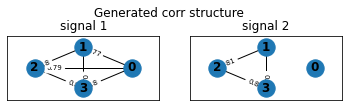

Continue with generated correlation structure?: y/n y


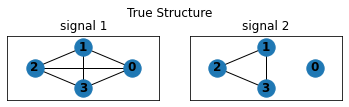

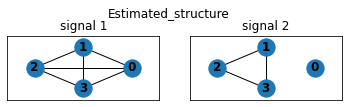

In [3]:
n_sets=4
signum=5

corr_obj = CorrelationStructureGen(n_sets=n_sets, signum=signum, tot_corr=[100,75], percentage=True)
corr_structure = corr_obj.get_structure()
corr_truth = corr_structure.corr_truth
datagen = MultisetDataGen_CorrMeans(corr_structure=corr_structure, M=300)

X, _ = datagen.generate()
corr_test = jointEVD(X, B=1000)
corr_estimate, d_cap = corr_test.find_structure()
plt.ion()
viz = visualization(graph_matrix=corr_truth, num_dataset=n_sets, label_edge=False)
viz.visualize("True Structure")
plt.ioff()
viz_op = visualization(graph_matrix=corr_estimate,num_dataset=n_sets, label_edge=False)
viz_op.visualize("Estimated_structure")


## Case 2 : Configure additional correlation structue parameters
This examples illustrates the usage of additional parameters with respect to the correlation structure generation.
The required correlation structure can be specified numerically with the required number of correlated subcomponents by setting the parameter`percentage=False`. Now the `tot_corr` can be specified numerically based on how many datasets a given signal is correlated.
The parameter `corr_means` configures the mean value of correlation between the correllated signals.
The parameter `corr_std` configures the standard deviation in the correlation.
The parameter `sigmad` sets the variance of the correlated components.
The parameter `sigmaf` sets the variance of the independent components.

Additionally, the jointEVD class can be configured with the probability of false alarm parameter by setting the `P_fa_eval` and `P_fa_evec` parameters

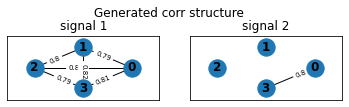

Continue with generated correlation structure?: y/n y


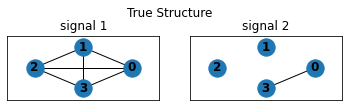

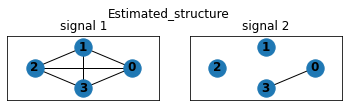

In [4]:
corr_obj = CorrelationStructureGen(n_sets=4, signum=5, tot_corr=[4,2], percentage=False,
                                   corr_means=[0.8, 0.8], corr_std=[0.01, 0.01], sigmad=10, sigmaf=3)
corr_structure = corr_obj.get_structure()
datagen = MultisetDataGen_CorrMeans(corr_structure=corr_structure, M=300)
corr_truth = corr_structure.corr_truth
X, _ = datagen.generate()
corr_test = jointEVD(X, B=1000, P_fa_eval=0.05, P_fa_evec=0.05)
corr_estimate, d_cap = corr_test.find_structure()
plt.ion()
viz = visualization(graph_matrix=corr_truth, num_dataset=4, label_edge=False)
viz.visualize("True Structure")
plt.ioff()
viz_op = visualization(graph_matrix=corr_estimate, label_edge=False)
viz_op.visualize("Estimated_structure")


## Case 3: Configure additional data generation parameters
For the `MultisetDataGen_CorrMeans` additional parameters can be configured.
`tot_dims` sets the dimensions in each of the datasets.
`mixing` configures the type of the mixing matrix in data generation.
`snr` configures the signal to noise ration in the data generation.


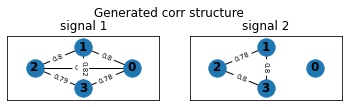

Continue with generated correlation structure?: y/n y


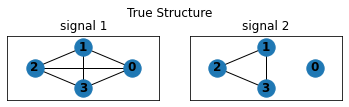

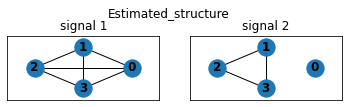

In [8]:
corr_obj = CorrelationStructureGen(n_sets=4, signum=5, tot_corr=[4,3], percentage=False,
                                   corr_means=[0.8, 0.8],tot_dims=6, corr_std=[0.01, 0.01], sigmad=10, sigmaf=3)
corr_structure= corr_obj.get_structure()
datagen = MultisetDataGen_CorrMeans(corr_structure, mixing='orth',
                                    snr=10, M=300)
corr_truth = corr_structure.corr_truth
X, _ = datagen.generate()
corr_test = jointEVD(X, B=1000)
corr_estimate, d_cap = corr_test.find_structure()
plt.ion()
viz = visualization(graph_matrix=corr_truth, num_dataset=4, label_edge=False)
viz.visualize("True Structure")
plt.ioff()
viz_op = visualization(graph_matrix=corr_estimate, label_edge=False)
viz_op.visualize("Estimated_structure")


## Case 4 Test with multiple snr values:

The below example demonstrates how additonal advanced parameters can be configured for a more detailed analysis:

Additionally, an analysis can be performed on multiple iterations for different SNR values, thus tracking the performance at different SNR's. This can be set as follows:
- `SNR_vec` accepts a list of SNR values for which the test has to be performed.
- `num_iter` sets the number of times the test is run for each SNR value. Performance for a particular SNR is averaged over `num_iter`.

The performance for different SNR values is measured using the Precision and Recall metric and plotted on a graph. The performance improves for higher SNR as expected.

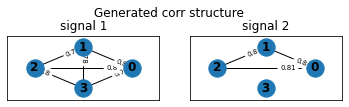

Continue with generated correlation structure?: y/n y


SNR val =  -5
iteration =  0
iteration =  1
iteration =  2
SNR val =  10
iteration =  0
iteration =  1
iteration =  2
SNR val =  15
iteration =  0
iteration =  1
iteration =  2
SNR val =  20
iteration =  0
iteration =  1
iteration =  2


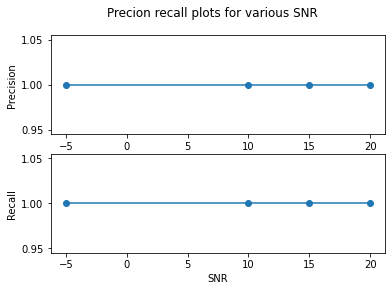

In [7]:
from mCorrect.metrics.metrics import Metrics

snr_vec=[-5, 10, 15, 20]
num_iter=3

prec_vec = []
rec_vec = []
corr_obj = CorrelationStructureGen(n_sets=4, signum=5, tot_corr=[4,3], percentage=False,
                                   corr_means=[0.8, 0.8], corr_std=[0.01,0.01], sigmad=10, sigmaf=3)
corr_structure = corr_obj.get_structure()
for snr in snr_vec:
    print("SNR val = ", snr)
    precision = 0
    recall = 0
    for i in range(num_iter):
        print("iteration = ", i)
        corr_truth = corr_structure.corr_truth
        datagen = MultisetDataGen_CorrMeans(corr_structure, mixing='orth',
                                    snr=10, M=300)
        corr_test = jointEVD(X, B=1000)
        corr_estimate, d_cap = corr_test.find_structure()
        perf = Metrics(corr_truth, corr_estimate)
        pr, re = perf.PrecisionRecall()
        precision += pr
        recall += re
    
    prec_vec.append(precision / num_iter)
    rec_vec.append(recall / num_iter)

plt.ion()
if len(snr_vec) > 1:
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Precion recall plots for various SNR')
    ax1.plot(snr_vec, prec_vec, 'o-')
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('SNR')

    ax2.plot(snr_vec, rec_vec, 'o-')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('SNR')
    plt.show()
       
    
    
    
    
    
